# Analisis Predictivo de Series Temporales

-----------


## Modelos en espacio de estados: modelos de Markov escondidos (HMM)

In [1]:
install.packages("astsa")
library("astsa")
install.packages("HiddenMarkov")
library("HiddenMarkov")
options(repr.plot.width=10, repr.plot.height=6) #ajusta tamaño de graficas


Installing package into 'C:/Users/jpmunoz/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'astsa' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jpmunoz\AppData\Local\Temp\RtmpOA2ibx\downloaded_packages


Warning message:
"package 'astsa' was built under R version 3.6.3"

## Ejercicio

Se desea realizar un modelo para la llegada de pacientes diarios a la emergencia de un hospital. Podemos suponer que:

 * El estado oculto de "demanda" es bajo, medio o alto. El estado de demanda solo puede cambiar de bajo a medio o medio a alto, o en sentido inverso (es decir, no se puede ir de bajo a alto directamente).
 
 * En promedio, la demanda se mantiene en el mismo estado por una semana. En el caso del estado "medio" va a "bajo" o "alto" con igual probabilidad.
 
 * Para cada estado, la cantidad de pacientes que llegan a la emergencia es una v.a. Poisson con media $\lambda_{bajo} =50$, $\lambda_{medio} = 75$ y $\lambda_{alto}=100$.
 
 * Se asume que la demanda comienza en estado "bajo".
 

1. Construir el modelo de HMM Poisson usando el comando `hmm = dthmm(NULL, P,delta,"pois",pm=list(lambda=lambdas))` donde `P`, `delta` y `lambdas` son los correspondientes al modelo anterior.

2. Simular una realización de la cadena durante un año usando `hmm = simulate(hmm,365)`.

3. Plotear las observaciones obtenidas (`hmm$x`) y realizar un histograma para evaluar clusters.

4. Realizar una estimación en 3 estados iniciales usando umbrales adecuados, y realizar una primera estimación `hmm_ini` de la cadena. Puede usarse como guía el ejemplo de Gaussianas anterior y la función `trans.matrix` para estimar $P$.

5. Mejorar la estimación usando Baum-Welch y Baum-Viterbi (pueden usarse los ejemplos y las funciones de más arriba). Comparar con la matriz P original y las medias originales.
 
6. Estudiar la estimación de estados lograda. Se puede comparar con los estados "oficiales" que quedan en `hmm$y`.


**Nota:** Para hacer Baum-Viterbi se debe modificar adecuadamente la función `baum_viterbi_normal` para usar la distribución Poisson. Esto implica que la cadena `hmm_fit` debe construirse con `distn="pois"` y debe proveerse únicamente la lista de lambdas, que se estiman por máxima verosimilitud como el promedio de las observaciones en cada estado. Baum Welch puede hacerse directamente pues ya viene programado.

1. Construcción del modelo

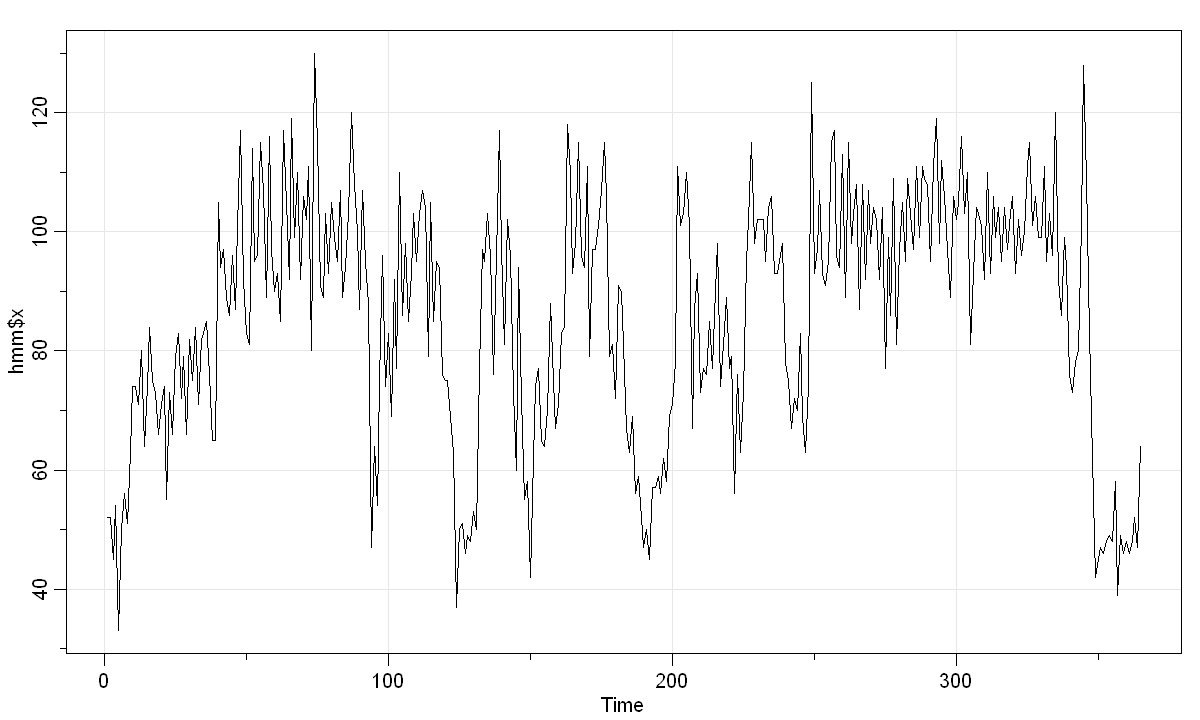

In [10]:
P <- matrix(c(6/7, 1/7, 0, 1/14 , 6/7 , 1/14 , 0, 1/7 , 6.7),byrow=TRUE, nrow=3)
delta <- c(1, 0,0)

2. Simular una realización de la cadena durante un año usando

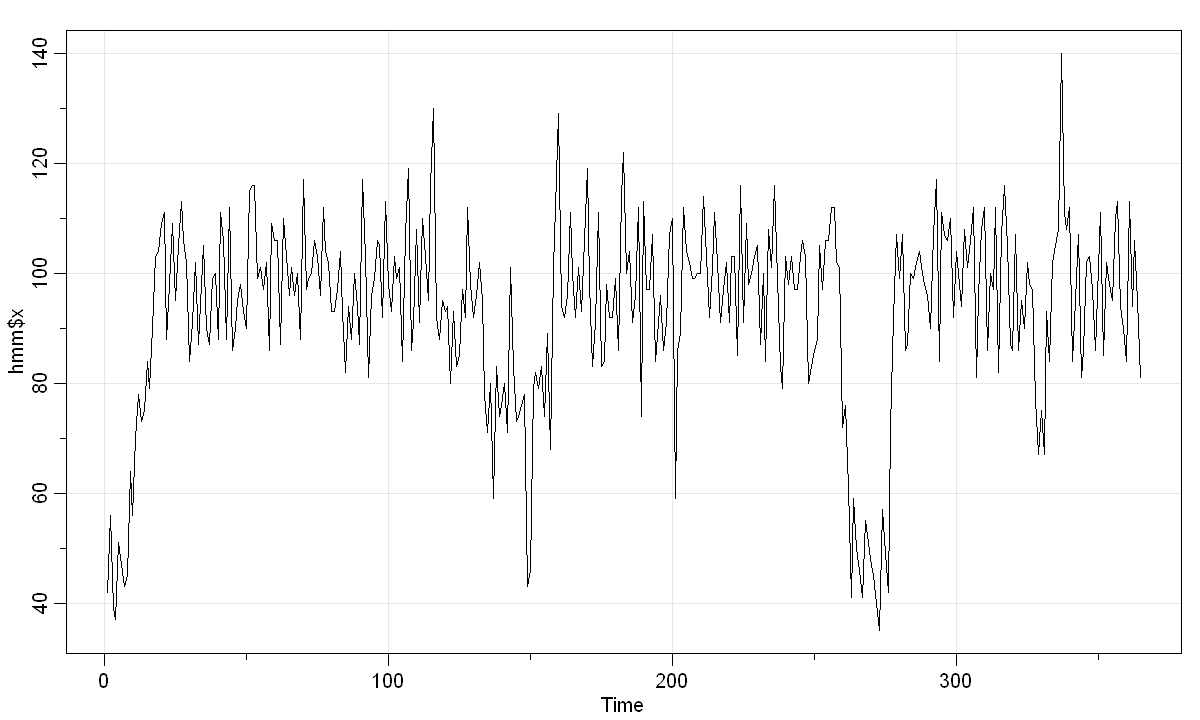

In [12]:
hmm <- dthmm(NULL, P, delta, "pois", pm=list(c(50, 75,100)))
hmm <- simulate(hmm, nsim=365)

3. Plotear las observaciones obtenidas (hmm$x) y realizar un histograma para evaluar clusters

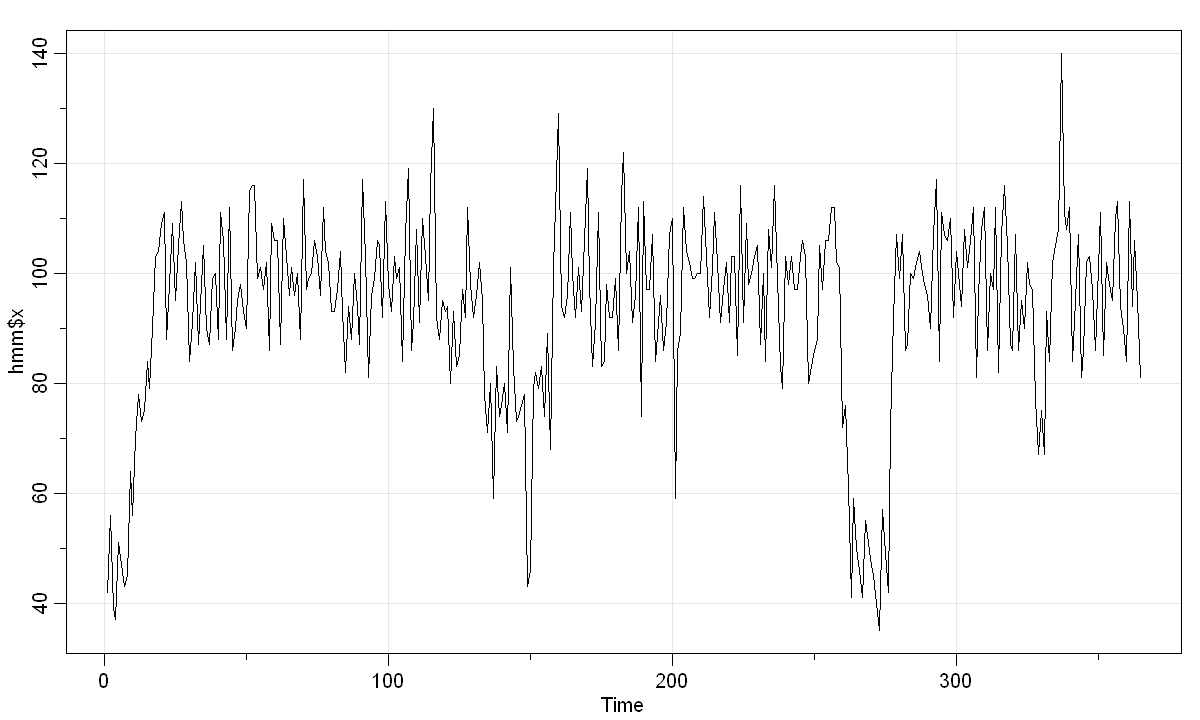

In [15]:
tsplot(hmm$x)

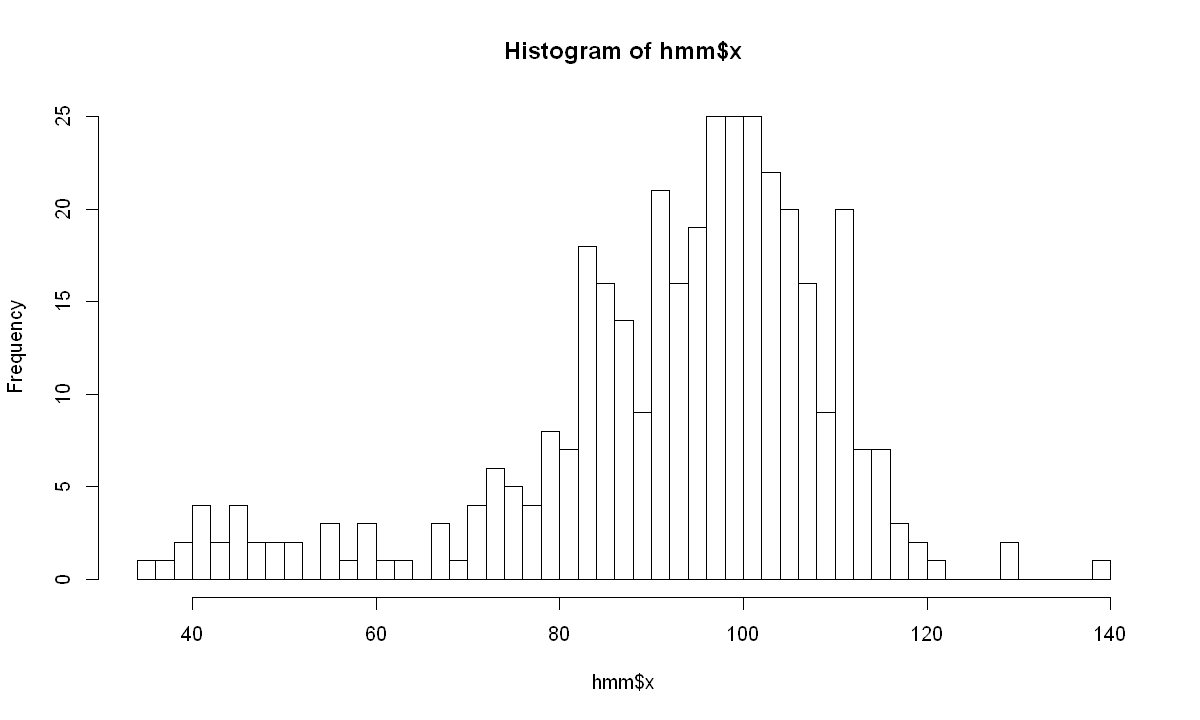

In [16]:
hist(hmm$x,breaks=60)

Genero las observaciones a mano para poder saber el estado que dio lugar a las mismas (HiddenMarkov no lo guarda, ver comentario anterior). Como podemos ver en el histograma, definimos 3 clusters. Hasta 60, otro hasta 80 y otro mayor que 80.

In [17]:
n=500

#P <- t(matrix(c(6/7, 1/7, 0, 1/14 , 6/7 , 1/14 , 0, 1/7 , 6.7),byrow=TRUE, nrow=3)
observations= hmm$x
estado_inicial= ifelse(observations < 60 , 1, ifelse(observations > 80 , 3 ,2))

# Esta funcion permite estimar la matriz de transiciones contando los saltos de estado.
trans.matrix <- function(X)
{
    X<-t(as.matrix(X))
    tt <- table( c(X[,-ncol(X)]), c(X[,-1]) )
    tt <- tt / rowSums(tt)
}


Construyo una estimacion inicial de la matriz

In [18]:
P_ini=trans.matrix(estado_inicial)
P_ini

   
              1           2           3
  1 0.777777778 0.148148148 0.074074074
  2 0.121212121 0.484848485 0.393939394
  3 0.003289474 0.042763158 0.953947368

Asigno probabilidad 1 al estado donde inicia la cadena.

In [19]:
delta_ini = as.numeric(estado_inicial[1] == (1:3))
delta_ini

[1] 1 0 0

Extraigo la media del comportamiento en cada estado asignado

In [29]:
lambda1 = mean(observations[estado_inicial==1])
lambda2 = mean(observations[estado_inicial==2])
lambda3 = mean(observations[estado_inicial==3])


lambda_ini = c(lambda1,lambda2, lambda3)
lambda_ini

[1] 47.48148 74.24242 99.05902

In [30]:
hmm_ini <- dthmm(observations, P_ini, delta_ini, "pois", list(lambda_ini))
hmm_ini

$x
  [1]  42  56  39  37  51  47  43  45  64  56  70  78  73  75  84  79  90 103
 [19] 104 109 111  88  98 109  95 105 113 106 102  84  91 102  87  98 105  90
 [37]  87  99 100  88 111 106  88 112  86  90  95  98  93  90 115 116 116  99
 [55] 101  97 102  86 109 106 106  87 110 103  96 101  96 100  88 117  97  99
 [73] 100 106 103  96 112 104 102  93  93  97 104  93  82  94  88 100  94  87
 [91] 117 103  81  96  99 106 105  92 113  98  93 103  99 101  84 107 119  86
[109]  91 108  91 110 103  95 116 130  92  88  95  93  94  80  93  83  85  97
[127]  92 112  98  92  96 102  95  78  71  80  59  83  74  76  80  71 101  83
[145]  73  74  76  78  43  46  79  82  79  83  74  89  68 101 112 129  94  92
[163]  96 111 100  92 101  93 106 119  98  83  91 111  83  84  98  92  92  99
[181]  86 114 122 100 104  91  96 112  74 113  97  97 107  84  91  96  86  91
[199] 107 110  59  86  89 112 104 102  99  99 100 100 114 103  92 101 111 102
[217]  91  97 102  91 103 103  85 116  91 109  98 100 103 105

Utilizamos el modelo de BaumWelch para ver como es el ajuste del modelo

In [22]:
hmm_fit <- BaumWelch(hmm_ini)
Viterbi(hmm_fit)

iter = 1 
LL = -1399.8817659 
diff = Inf 

iter = 2 
LL = -1389.2074942 
diff = 10.67427 

iter = 3 
LL = -1388.0932822 
diff = 1.114212 

iter = 4 
LL = -1387.9429529 
diff = 0.1503293 

iter = 5 
LL = -1387.9246732 
diff = 0.01827962 

iter = 6 
LL = -1387.9225949 
diff = 0.002078322 

iter = 7 
LL = -1387.9223600 
diff = 0.0002349027 

iter = 8 
LL = -1387.9223328 
diff = 2.725316e-05 

iter = 9 
LL = -1387.9223295 
diff = 3.298841e-06 



[1] 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [38] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [75] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[149] 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[186] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[223] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[260] 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[297] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 3 3
[334] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

Utilizamos la formula brindada para implementar Viterbi y la ajustamos a nuestro modelo

In [31]:

baum_viterbi_poisson <- function(hmm_ini,tol=1e-3,maxiter=10) {
    
    paso = Inf #incremento de la verosimilitud
    k = 0 #no. de iteracion
    N = nrow(hmm_ini$P) #no. de estados
    
    hmm_fit = hmm_ini #en hmm_fit guardo la salida. Arranca igual a hmm_ini
    
    while (paso>tol && k<maxiter) {

        lL_ini =  logLik(hmm_fit) #guardo la verosimilitud anterior
        x = Viterbi(hmm_fit) #recupero los estados mas probables
      
        #Reestimo los parametros:
        delta = as.numeric(x[1] == (1:N))
        P = trans.matrix(x)

        #Construyo un vector para medias y varianzas y los lleno con los estimadores filtrando por estado
        lambda = vector()
        for (i in 1:N) {
            lambda[i] = mean(hmm_fit$x[x==i])
        }
 
        hmm_fit = dthmm(hmm_fit$x, Pi=P, delta=delta, distn="pois", pm= list(lambda))
        paso = abs(logLik(hmm_fit)-lL_ini) #calculo cuanto mejora la verosimilitud
        k = k+1 #incremento el contador de iteraciones
        
        print(paste("Paso: ",k))
        print(paste("Verosimilud: ",logLik(hmm)))
    }
    return(hmm_fit)
}

Utilizamos el modelo de BaumViterbi para ver como es el ajuste del modelo

In [32]:
hmm_fit2 <- baum_viterbi_poisson(hmm_ini)
Viterbi(hmm_fit2)
hmm_fit2


[1] "Paso:  1"
[1] "Verosimilud:  -810.735380288143"
[1] "Paso:  2"
[1] "Verosimilud:  -810.735380288143"
[1] "Paso:  3"
[1] "Verosimilud:  -810.735380288143"
[1] "Paso:  4"
[1] "Verosimilud:  -810.735380288143"


[1] 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [38] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [75] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[149] 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[186] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[223] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[260] 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[297] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 3 3
[334] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

$x
  [1]  42  56  39  37  51  47  43  45  64  56  70  78  73  75  84  79  90 103
 [19] 104 109 111  88  98 109  95 105 113 106 102  84  91 102  87  98 105  90
 [37]  87  99 100  88 111 106  88 112  86  90  95  98  93  90 115 116 116  99
 [55] 101  97 102  86 109 106 106  87 110 103  96 101  96 100  88 117  97  99
 [73] 100 106 103  96 112 104 102  93  93  97 104  93  82  94  88 100  94  87
 [91] 117 103  81  96  99 106 105  92 113  98  93 103  99 101  84 107 119  86
[109]  91 108  91 110 103  95 116 130  92  88  95  93  94  80  93  83  85  97
[127]  92 112  98  92  96 102  95  78  71  80  59  83  74  76  80  71 101  83
[145]  73  74  76  78  43  46  79  82  79  83  74  89  68 101 112 129  94  92
[163]  96 111 100  92 101  93 106 119  98  83  91 111  83  84  98  92  92  99
[181]  86 114 122 100 104  91  96 112  74 113  97  97 107  84  91  96  86  91
[199] 107 110  59  86  89 112 104 102  99  99 100 100 114 103  92 101 111 102
[217]  91  97 102  91 103 103  85 116  91 109  98 100 103 105

Comparamos las matrices P y vemos que ambos algoritmos nos dan resultados similares

In [25]:
sum((hmm_fit$Pi-P)**2)
sum((hmm_fit2$Pi-P)**2)

[1] 32.70117

[1] 32.66615

Comparando ambos algoritmos vemos que se obtiene un menor error con el algoritmo Baum-Viterbi

In [26]:
lambda=c(50,75,100)
#hmm_fit$pm$lambda
#hmm_fit2$pm[[1]]
sum((hmm_fit$pm$lambda-lambda)**2)
sum((hmm_fit2$pm[[1]]-lambda)**2)

[1] 10.41805

[1] 9.152882

Comparando las asignaciones de cada observacion diaria en cada estado vemos que los algoritmo le erran solo a 4 observaciones.

In [33]:
sum((Viterbi(hmm_fit)-hmm$y)**2)
sum((Viterbi(hmm_fit2)-hmm$y)**2)

[1] 1

[1] 1